# GCN with StellarGraph

- dataset: Twitter

## start with node-classification

In [1]:
import networkx as nx
import stellargraph as sg
import pandas as pd
import numpy as np
import json
import warnings
import tensorflow as tf

from sklearn import preprocessing, model_selection

from tensorflow.keras import layers, Model, optimizers, losses, callbacks
from tensorflow.keras.layers import LeakyReLU

warnings.filterwarnings('ignore')
np.random.seed(0)
tf.random.set_seed(0)

### graph setting
- it should contain all nodes even if would not use some nodes
- making target through train-test splitting

In [2]:
# set edges
edges = pd.read_table('../datasets/twitter/users.edges', header=None, sep=' ')
edges.columns = ['source', 'target'] # should be follow this column name
gx = nx.from_pandas_edgelist(edges) # stellar graph form

# load features
all_features = pd.read_table('../datasets/twitter/users_hate_all.content', header=None, index_col=0)
all_features[321] = all_features[321].replace(['hateful', 'normal', 'other'], [0, 1, 2])
features = all_features[all_features[321] != 2]
target = all_features[all_features[321] != 2][321]
all_features = all_features.drop(321, axis=1)

# make graph
G = sg.StellarGraph(gx, node_features=all_features)
nodes = list(G.nodes())
print(G.info())


StellarGraph: Undirected multigraph
 Nodes: 100386, Edges: 2194979

 Node types:
  default: [100386]
    Features: float32 vector, length 320
    Edge types: default-default->default

 Edge types:
    default-default->default: [2194979]


### val-test split and OHE

In [3]:
tr_X, val_X, tr_target, val_target = model_selection.train_test_split(
    features, target, train_size=0.2, stratify=target
)

val_X, test_X, val_target, test_target = model_selection.train_test_split(
    val_X, val_target, train_size=0.5, stratify=val_target
)

In [4]:
lbe = preprocessing.LabelBinarizer()

tr_target = pd.DataFrame(lbe.fit_transform(tr_target.values), index=tr_target.index)
val_target = pd.DataFrame(lbe.fit_transform(val_target.values), index=val_target.index)
test_target = pd.DataFrame(lbe.fit_transform(test_target.values), index=test_target.index)
tot_target = pd.DataFrame(lbe.fit_transform(target.values), index=target.index)

### node generator
- it make seperate node set with edges

In [5]:
from stellargraph.mapper import FullBatchNodeGenerator

generator = FullBatchNodeGenerator(G, method="gcn")


Using GCN (local pooling) filters...


In [6]:
tr_flow = generator.flow(tr_target.index, tr_target) # node_id, target
val_flow = generator.flow(val_target.index, val_target)
test_flow = generator.flow(test_target.index, test_target)
tot_flow = generator.flow(target.index, target)

### build implemented model

In [7]:
from stellargraph.layer import GCN

gcn = GCN(layer_sizes=[32, 32], activations=[LeakyReLU(0.3), LeakyReLU(0.3)], generator=generator, dropout=0.3)
nc_inp, nc_out = gcn.build()


### inject a few layer(FC) to better do ML things

In [8]:
nc_layer = layers.Dense(16, activation=LeakyReLU(0.3))(nc_out)
nc_layer = layers.Dense(1, activation='sigmoid')(nc_layer)

nc_model = Model(inputs=nc_inp, outputs=nc_layer)
nc_model.compile(
    optimizer=optimizers.Adam(lr=1e-3),
    loss=losses.binary_crossentropy,
    metrics=["acc"],
)

In [9]:
es = callbacks.EarlyStopping(patience=10, restore_best_weights=True, monitor='val_acc')
nc_hist = nc_model.fit(tr_flow, epochs=200,
                validation_data=val_flow,
                shuffle=False, # should be False!!
                callbacks=[es],
                verbose=0)  

  ...
    to  
  ['...']
  ...
    to  
  ['...']


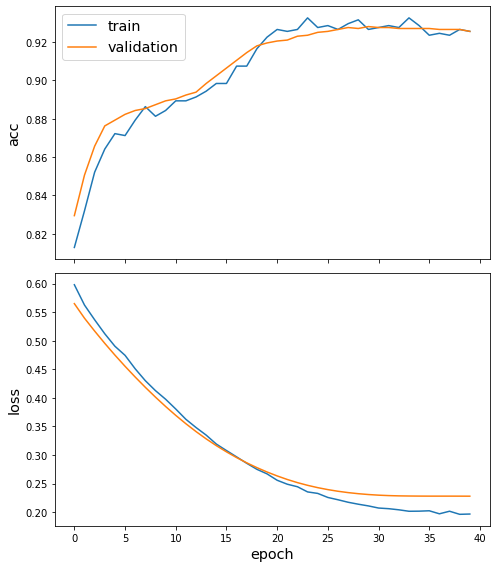

In [10]:
sg.utils.plot_history(nc_hist)

In [11]:
from sklearn.metrics import f1_score

f1_micro = f1_score(test_target.values, list(map(lambda x: 1 if x>0.5 else 0, (nc_model.predict(test_flow).squeeze()))), average='micro')
f1_marco = f1_score(test_target.values, list(map(lambda x: 1 if x>0.5 else 0, (nc_model.predict(test_flow).squeeze()))), average='macro')

print('f1_micro:', round(f1_micro,3), '\nf1_macro:', round(f1_marco, 3)) 



f1_micro: 0.929 
f1_macro: 0.79


### comparison with non-graph classification

In [12]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression().fit(features.loc[tr_target.index], tr_target)

f1_micro = f1_score(test_target.values, lr.predict(features.loc[test_target.index]), average='micro')
f1_macro = f1_score(test_target.values, lr.predict(features.loc[test_target.index]), average='macro')

print('f1_micro:', round(f1_micro,3), '\nf1_macro:', round(f1_marco, 3)) 


f1_micro: 0.987 
f1_macro: 0.79


### visualize how it classify

In [13]:
emb_model = Model(nc_inp, nc_out)

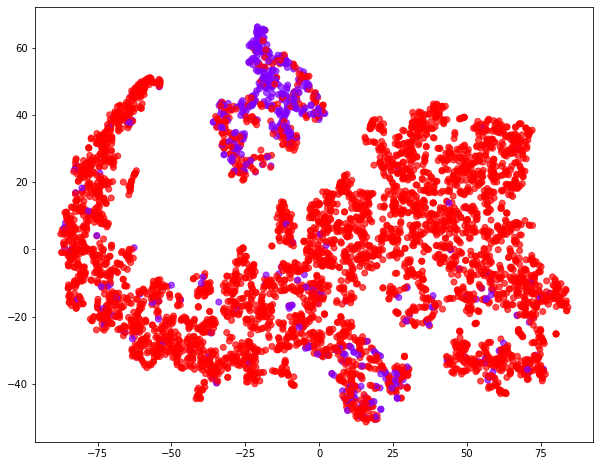

In [14]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2)
tsne_x = tsne.fit_transform(emb_model.predict(tot_flow).squeeze())

lbe = preprocessing.LabelEncoder()
col = lbe.fit_transform(target)

alpha = 0.7

plt.figure(figsize=(10, 8))
plt.scatter(
    tsne_x[:, 0],
    tsne_x[:, 1],
    cmap="rainbow",
    c=col,
    alpha=alpha,
)